<a href="https://colab.research.google.com/github/JoJoYao996/Deeplearning_with_Pytorch/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10: Train Loss: 1.8486, Train Acc: 31.38%, Test Loss: 1.0690, Test Acc: 51.81%
Epoch 2/10: Train Loss: 0.6471, Train Acc: 75.52%, Test Loss: 0.4725, Test Acc: 81.91%
Epoch 3/10: Train Loss: 0.4247, Train Acc: 84.10%, Test Loss: 0.5414, Test Acc: 78.27%
Epoch 4/10: Train Loss: 0.3688, Train Acc: 86.27%, Test Loss: 0.3705, Test Acc: 86.40%
Epoch 5/10: Train Loss: 0.3221, Train Acc: 87.90%, Test Loss: 0.3175, Test Acc: 88.11%
Epoch 6/10: Train Loss: 0.2924, Train Acc: 88.97%, Test Loss: 0.3350, Test Acc: 87.18%
Epoch 7/10: Train Loss: 0.2700, Train Acc: 89.71%, Test Loss: 0.3055, Test Acc: 88.70%
Epoch 8/10: Train Loss: 0.2471, Train Acc: 90.73%, Test Loss: 0.2908, Test Acc: 89.42%
Epoch 9/10: Train Loss: 0.2326, Train Acc: 91.32%, Test Loss: 0.2572, Test Acc: 90.40%
Epoch 10/10: Train Loss: 0.2189, Train Acc: 91.81%, Test Loss: 0.2747, Test Acc: 90.25%


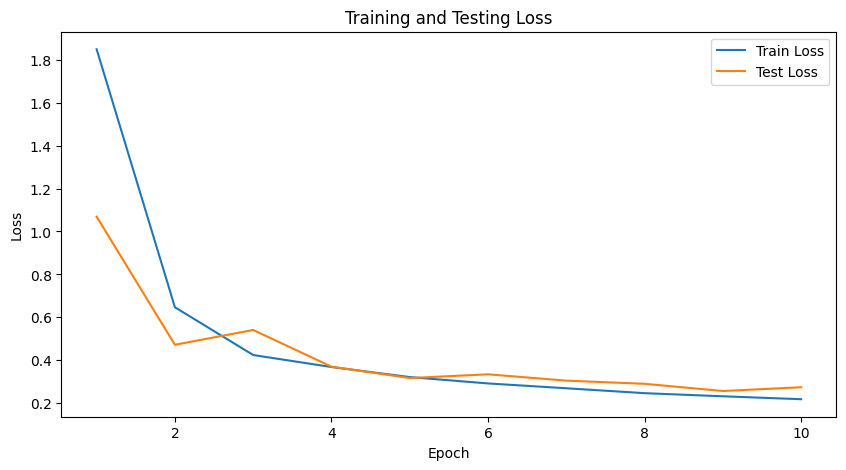

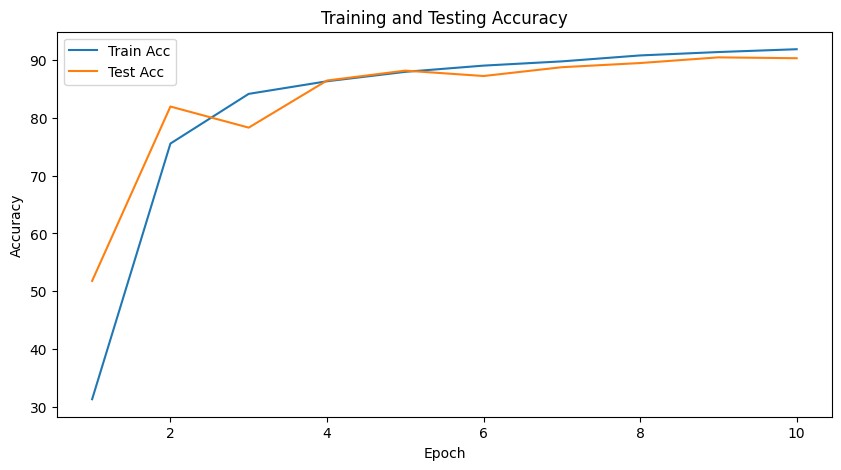

In [6]:
import warnings
warnings.filterwarnings('ignore')
# 导入相关库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# inception块
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

# 构建google-Net
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))


# Xavier初始化：防止梯度爆炸，这是CNN常用的操作，特别对于GoogleNet这种已经算比较深的网络而言，特别有效，之前我们也介绍过他的具体公式。
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: #对全连接层和卷积层初始化
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 检查是否有可用的GPU
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model = net.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# 加载Fashion-MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96,96)),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)



# 训练模型
num_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(trainloader)
    train_accuracy = 100*train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    test_loss = 0.0
    test_total = 0
    test_correct = 0

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_accuracy =  100*test_correct / test_total
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# 绘制训练误差和测试误差曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# 绘制训练准确率和测试准确率曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, num_epochs+1), test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()
